In [1]:
import os
import ast
import re
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants

# Summarize baseline results into Pandas DataFrame

In [2]:
def summarize(path, fname):
    model_meta = pd.read_parquet(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['train_loss', 'train_acc', 'valid_loss', 'valid_acc']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_loss'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_loss'].apply(lambda x: x[-1])
    model_meta['final_valid_acc'] = model_meta['valid_acc'].apply(lambda x: x[-1])
    model_meta['final_valid_loss'] = model_meta['valid_loss'].apply(lambda x: x[-1])
    model_meta['best_valid_loss'] = model_meta['valid_loss'].apply(min)
    model_meta['best_valid_loss_epoch'] = model_meta['valid_loss'].apply(lambda x: len(x[:np.argmin(x)]))

    return model_meta

In [3]:
model_meta = pd.DataFrame()

root_dir = os.path.join(constants.FINE_TUNING_RESULTS_DIR,
                        'disable_stats',
                        'disable_src_enable_tgt',
                        'fine_tune_all')
base_dir = os.path.join(constants.FINE_TUNING_RESULTS_DIR,
                        'disable_stats',
                        'disable_src_disable_tgt')
source_train_baseline_dir = os.path.join(base_dir, 'disable_src_all_s_20k_t_20')
exp_dir = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

for f in os.listdir(source_train_baseline_dir):
    if f.endswith('.parquet') and f.startswith('source'):
        trial_results = summarize(os.path.join(root_dir, source_train_baseline_dir), f)
        phase, _, iter_idx, _ = re.split('[_.]', f)
        trial_results.loc[:, 'phase'] = phase
        trial_results.loc[:, 'iter_idx'] = iter_idx

        try:
            with open(os.path.join(root_dir, source_train_baseline_dir, f'args_{iter_idx}.json')) as arg_f:
                args = json.load(arg_f)
        except OSError:
            print('No corresponding args.json file associated with trial!')

        for key in ['num_source_epochs', 'num_target_epochs', 'source_lr', 'target_lr', 'source_batch_size', 'target_batch_size',
                    'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
            trial_results.loc[:, key] = args[key]

        model_meta  = model_meta.append(trial_results, ignore_index=True)
    
for d in exp_dir:
    for f in os.listdir(os.path.join(root_dir, d)):
        if (f.endswith('.parquet')) and ('target' in f):
            trial_results = summarize(os.path.join(root_dir, d), f)
            phase, _, iter_idx, _ = re.split('[_.]', f)
            trial_results.loc[:, 'phase'] = phase
            trial_results.loc[:, 'iter_idx'] = iter_idx

            try:
                with open(os.path.join(root_dir, d, f'args_{iter_idx}.json')) as arg_f:
                    args = json.load(arg_f)
            except OSError:
                print('No corresponding args.json file associated with trial!')

            for key in ['num_source_epochs', 'num_target_epochs', 'source_lr', 'target_lr', 'source_batch_size', 'target_batch_size',
                        'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
                trial_results.loc[:, key] = args[key]

            model_meta = model_meta.append(trial_results, ignore_index=True)
        

# Summarize performance for trained models

In [4]:
source_meta = model_meta[model_meta['phase'] == 'source']

performance_cols = ['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc',
                    'chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc']

In [5]:
source_meta.mean()[performance_cols]

mimic_test_loss       0.611082
mimic_test_acc        0.770243
mimic_test_auc        0.842868
chexpert_test_loss    0.575049
chexpert_test_acc     0.854583
chexpert_test_auc     0.917258
dtype: float64

In [6]:
target_meta = model_meta[model_meta['phase'] == 'target']

performance_cols = ['mimic_best_test_loss', 'mimic_final_test_loss', 'mimic_best_test_acc', 'mimic_final_test_acc',
                    'chexpert_best_test_loss', 'chexpert_final_test_loss', 'chexpert_best_test_acc', 'chexpert_final_test_acc']

In [7]:
target_meta.groupby('n_target_samples').max(numeric_only=True)[performance_cols].round(3)

mimic_best_test_loss  mimic_final_test_loss  \
n_target_samples                                                
20                               0.630                  0.630   
50                               0.639                  0.640   
100                              0.617                  0.618   
200                              0.623                  0.617   
500                              0.616                  0.613   
1000                             0.607                  0.609   

                  mimic_best_test_acc  mimic_final_test_acc  \
n_target_samples                                              
20                              0.776                 0.770   
50                              0.779                 0.778   
100                             0.782                 0.782   
200                             0.781                 0.781   
500                             0.797                 0.796   
1000                            0.805                 0.804   

                  chexpert_best_test_loss  chexpert_final_test_loss  \
n_target_samples                                                      
20                                  0.584                     0.597   
50                                  0.585                     0.584   
100                                 0.579                     0.579   
200                                 0.607                     0.599   
500                                 0.584                     0.595   
1000                                0.611                     0.609   

                  chexpert_best_test_acc  chexpert_final_test_acc  
n_target_samples                                                   
20                                 0.852                    0.852  
50                                 0.847                    0.846  
100                                0.859                    0.859  
200                                0.858                    0.858  
500                                0.854                    0.859  
1000                               0.856                    0.857

In [8]:
target_meta.groupby('n_target_samples').mean()[performance_cols].round(3)

mimic_best_test_loss  mimic_final_test_loss  \
n_target_samples                                                
20                               0.621                  0.620   
50                               0.625                  0.625   
100                              0.615                  0.614   
200                              0.615                  0.612   
500                              0.610                  0.607   
1000                             0.606                  0.606   

                  mimic_best_test_acc  mimic_final_test_acc  \
n_target_samples                                              
20                              0.771                 0.765   
50                              0.767                 0.767   
100                             0.777                 0.775   
200                             0.778                 0.780   
500                             0.792                 0.794   
1000                            0.801                 0.799   

                  chexpert_best_test_loss  chexpert_final_test_loss  \
n_target_samples                                                      
20                                  0.577                     0.582   
50                                  0.578                     0.578   
100                                 0.575                     0.576   
200                                 0.585                     0.581   
500                                 0.579                     0.584   
1000                                0.594                     0.593   

                  chexpert_best_test_acc  chexpert_final_test_acc  
n_target_samples                                                   
20                                 0.829                    0.815  
50                                 0.828                    0.829  
100                                0.837                    0.832  
200                                0.841                    0.847  
500                                0.851                    0.849  
1000                               0.844                    0.844

In [9]:
target_meta.groupby('n_target_samples').std()[performance_cols].round(3)

mimic_best_test_loss  mimic_final_test_loss  \
n_target_samples                                                
20                               0.008                  0.009   
50                               0.013                  0.014   
100                              0.003                  0.004   
200                              0.007                  0.005   
500                              0.007                  0.006   
1000                             0.000                  0.002   

                  mimic_best_test_acc  mimic_final_test_acc  \
n_target_samples                                              
20                              0.005                 0.006   
50                              0.011                 0.011   
100                             0.005                 0.006   
200                             0.004                 0.001   
500                             0.005                 0.002   
1000                            0.004                 0.005   

                  chexpert_best_test_loss  chexpert_final_test_loss  \
n_target_samples                                                      
20                                  0.006                     0.014   
50                                  0.006                     0.005   
100                                 0.003                     0.003   
200                                 0.019                     0.015   
500                                 0.005                     0.010   
1000                                0.015                     0.014   

                  chexpert_best_test_acc  chexpert_final_test_acc  
n_target_samples                                                   
20                                 0.029                    0.056  
50                                 0.030                    0.028  
100                                0.023                    0.024  
200                                0.022                    0.018  
500                                0.004                    0.011  
1000                               0.021                    0.019

In [10]:
mimic_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['mimic_final_test_loss', 'mimic_final_test_acc', 'mimic_final_test_auc'])
chex_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['chexpert_final_test_loss', 'chexpert_final_test_acc', 'chexpert_final_test_auc'])

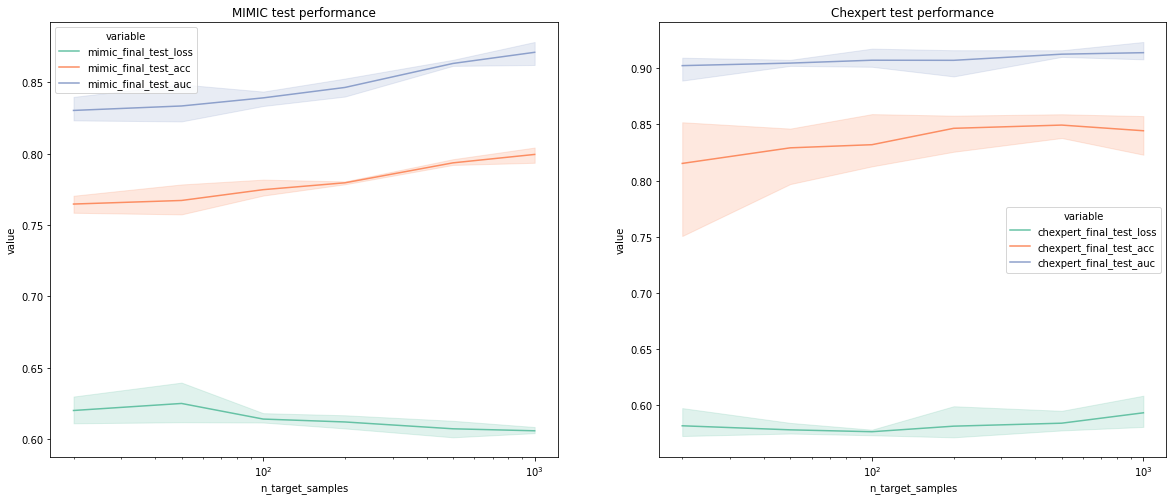

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(data=mimic_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[0])
ax[0].set_title('MIMIC test performance')
ax[0].set(xscale='log')
sns.lineplot(data=chex_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[1])
ax[1].set_title('Chexpert test performance')
ax[1].set(xscale='log');

# Visualize training and validation losses for the two training phases

In [12]:
def plot_losses(df, phase='target', n_target_samples=20, loss_type='train', ax=None):
   
    if phase == 'target':
        df = df[df['n_target_samples'] == n_target_samples].copy()
    subset_df = df[df['phase'] == phase].copy()
    key = f'{loss_type}_loss'
    max_len = max([len(ele) for ele in subset_df.loc[:, key].values])
    stackable = [np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan) for arr in subset_df.loc[:, key].values]
    losses = np.stack(stackable)

    avg_loss = np.mean(losses, axis=0)
    upper_ = avg_loss + np.std(losses, axis=0)
    lower_ = avg_loss - np.std(losses, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_loss, 'k--')
    ax.plot(losses.T)
    ax.legend(['average loss', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='upper right')

    ax.set_title(f'{loss_type} loss on the {phase} domain'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('BCE loss')


## 20 MIMIC samples

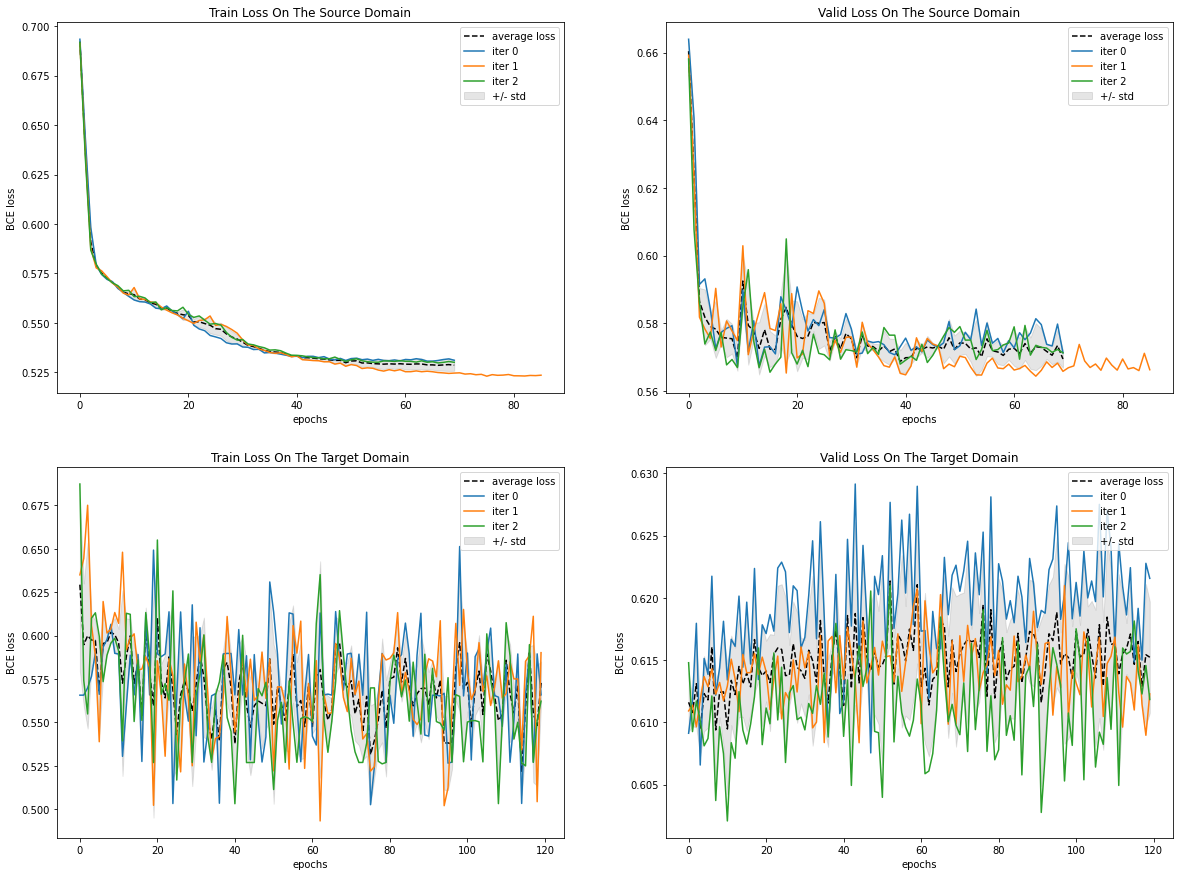

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 20

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 50 MIMIC samples

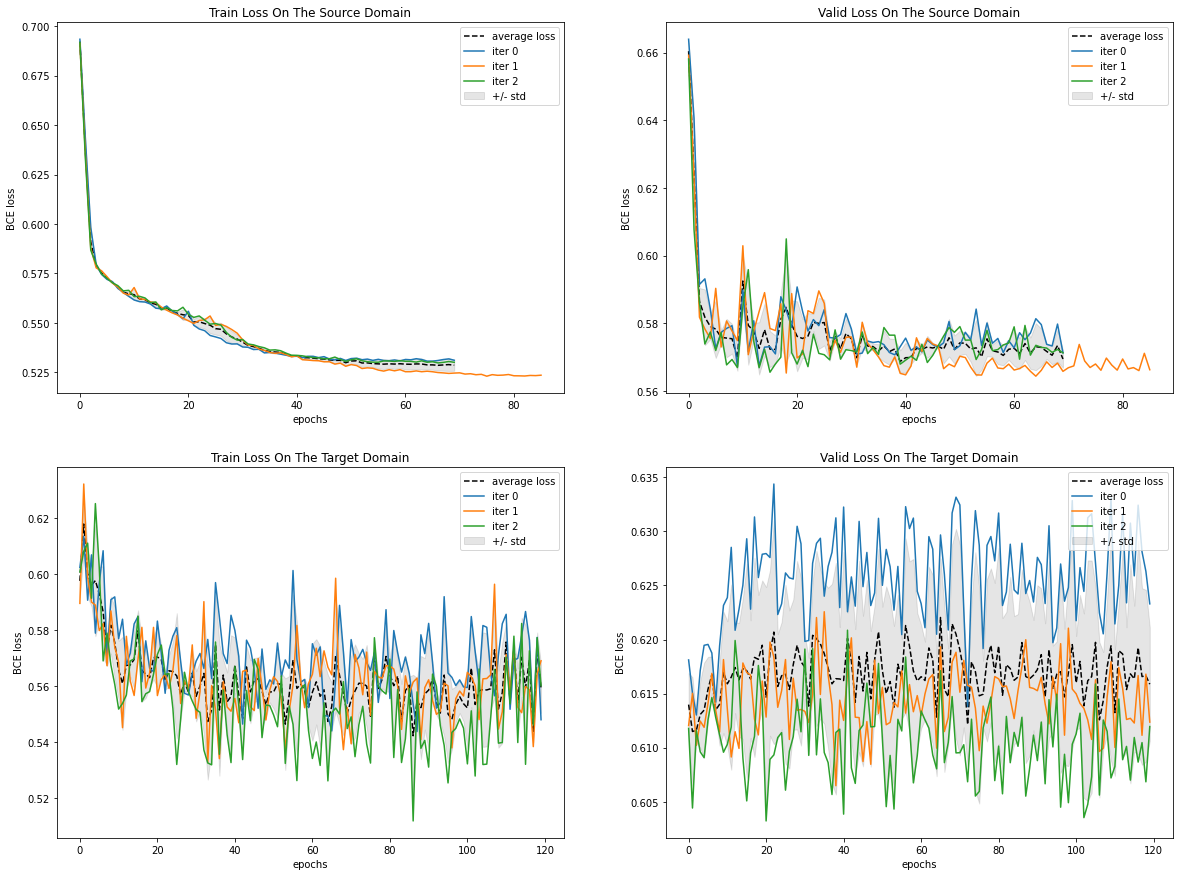

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 50

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 100 MIMIC samples

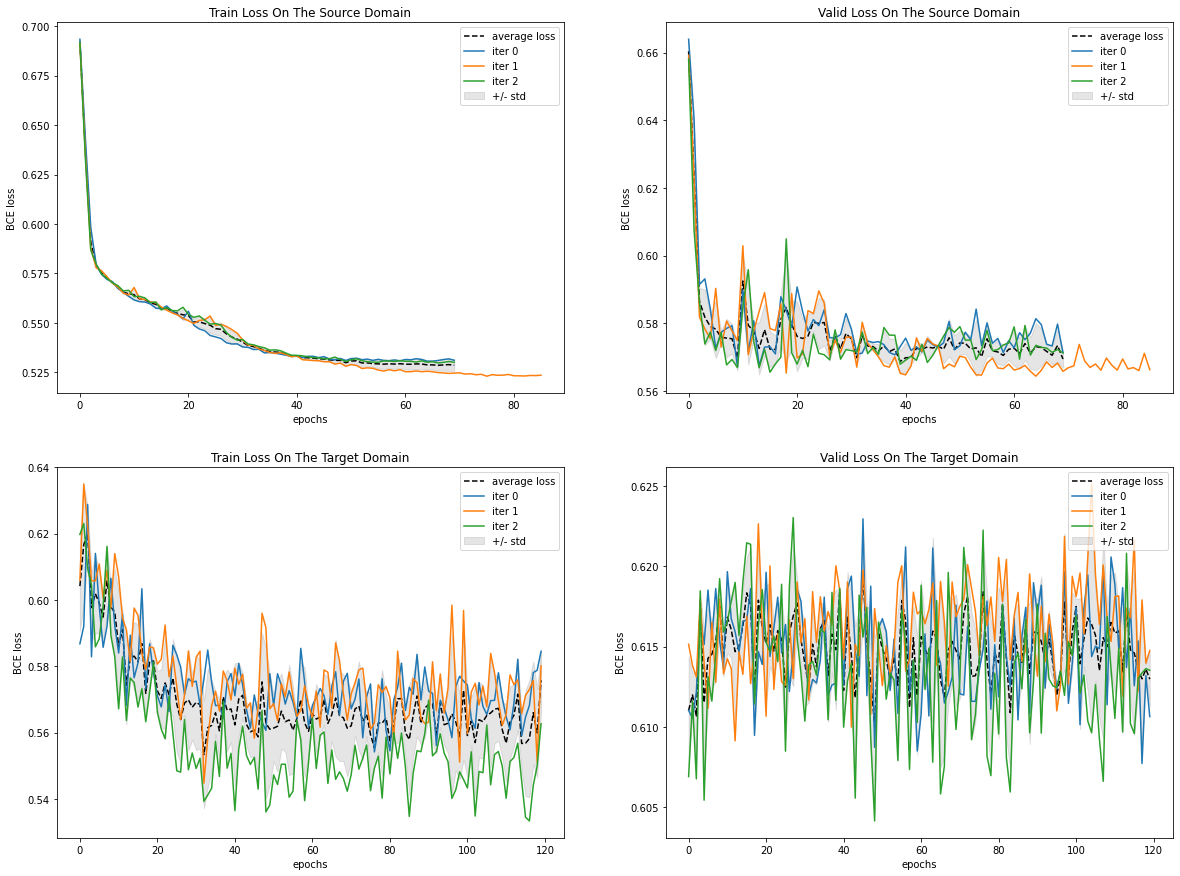

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 100

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 200 MIMIC samples

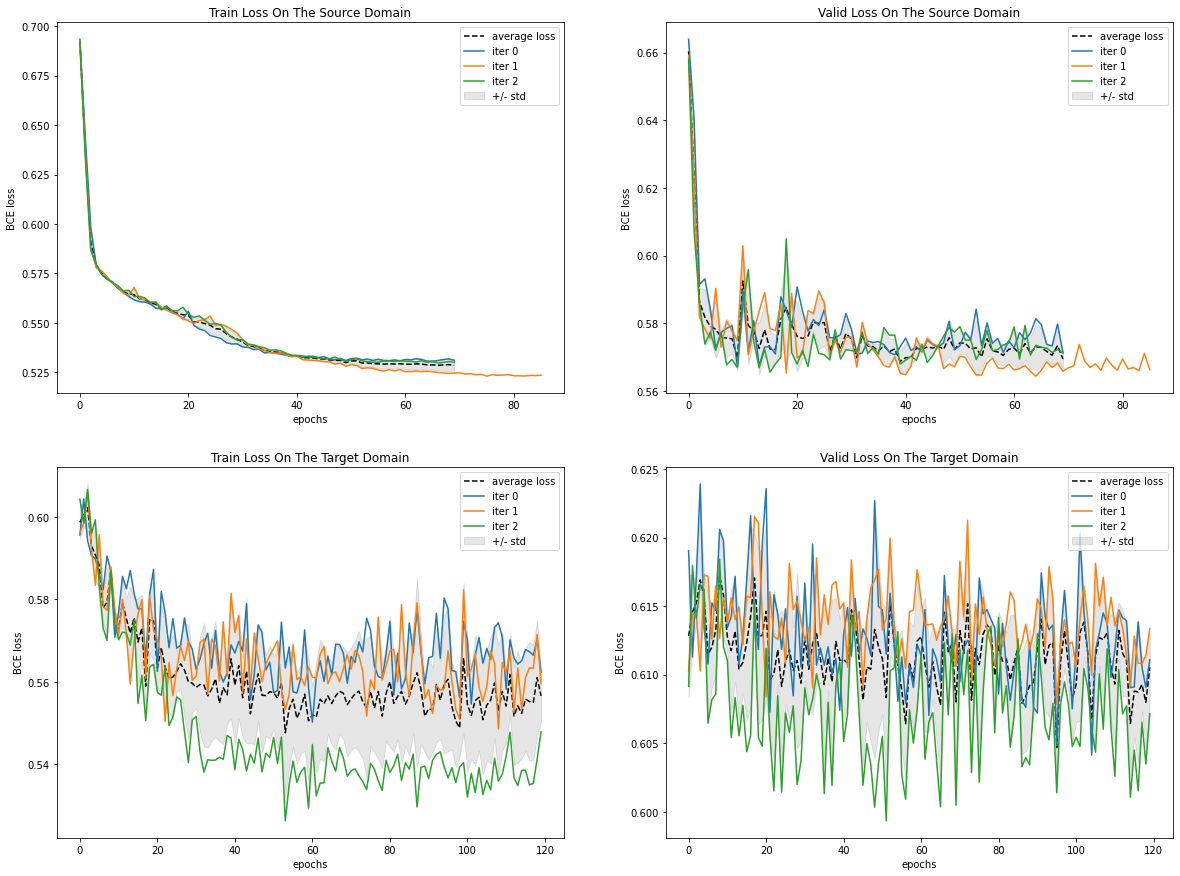

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 200

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 500 MIMIC samples

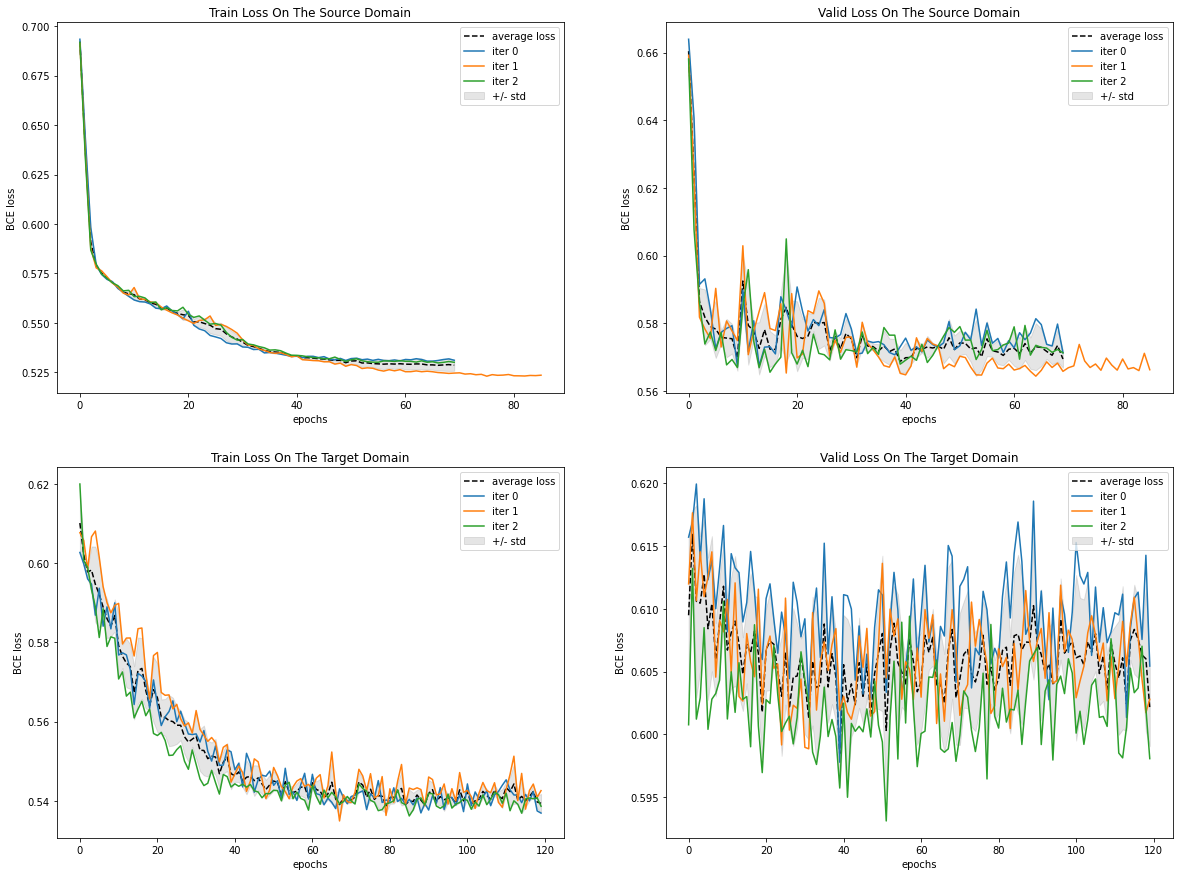

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 500

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 1000 MIMIC samples

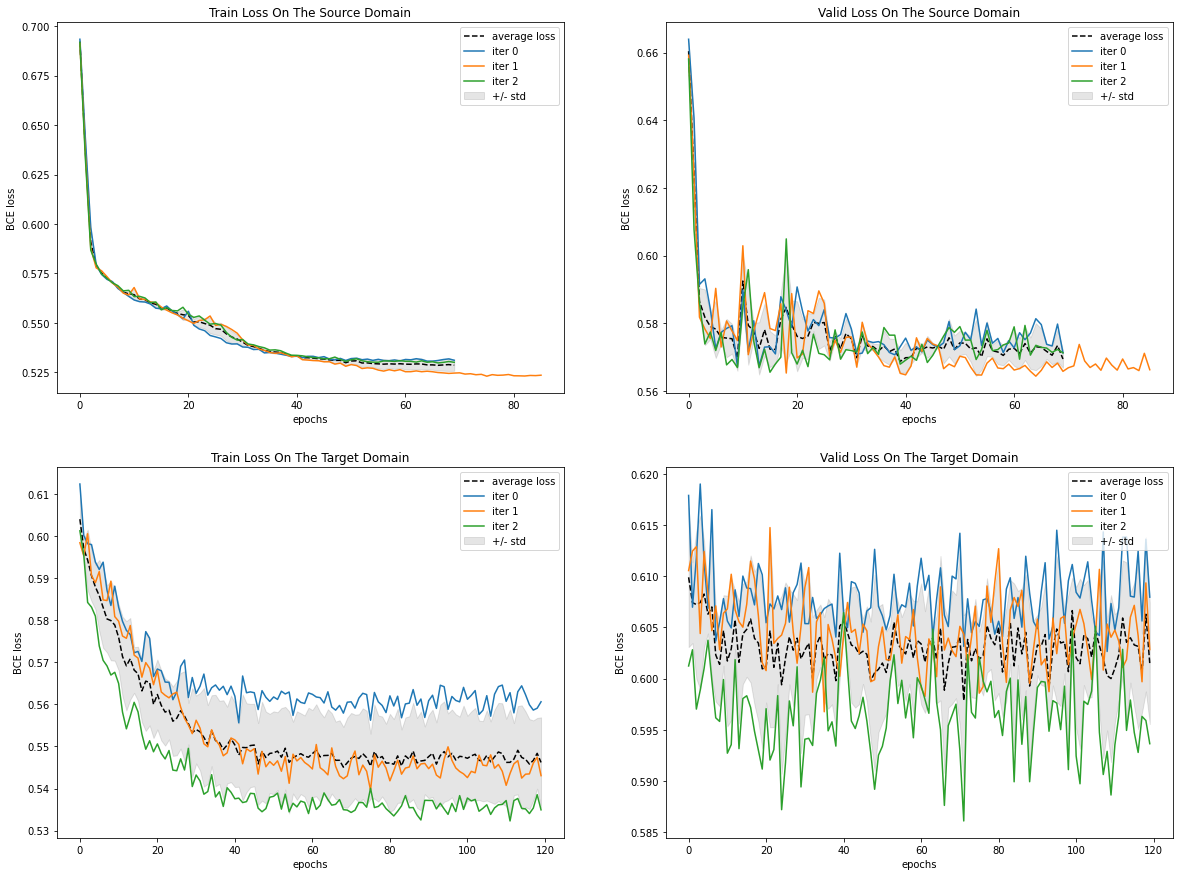

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 1000

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

# Visualize training and validation accuracies for the two training phases

In [19]:
def plot_accuracies(df, phase='target', n_target_samples=20, acc_type='train', ax=None):
   
    if phase == 'target':
        df = df[df['n_target_samples'] == n_target_samples].copy()
    subset_df = df[df['phase'] == phase].copy()
    key = f'{acc_type}_acc'
    max_len = max([len(ele) for ele in subset_df.loc[:, key].values])
    stackable = [np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan) for arr in subset_df.loc[:, key].values]
    acc = np.stack(stackable)

    avg_acc = np.mean(acc, axis=0)
    upper_ = avg_acc + np.std(acc, axis=0)
    lower_ = avg_acc - np.std(acc, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_acc, 'k--')
    ax.plot(acc.T)
    ax.legend(['average accuracy', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='lower right')

    ax.set_title(f'{acc_type} Accuracy on the {phase} domain'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('Accuracy')


## 20 MIMIC samples

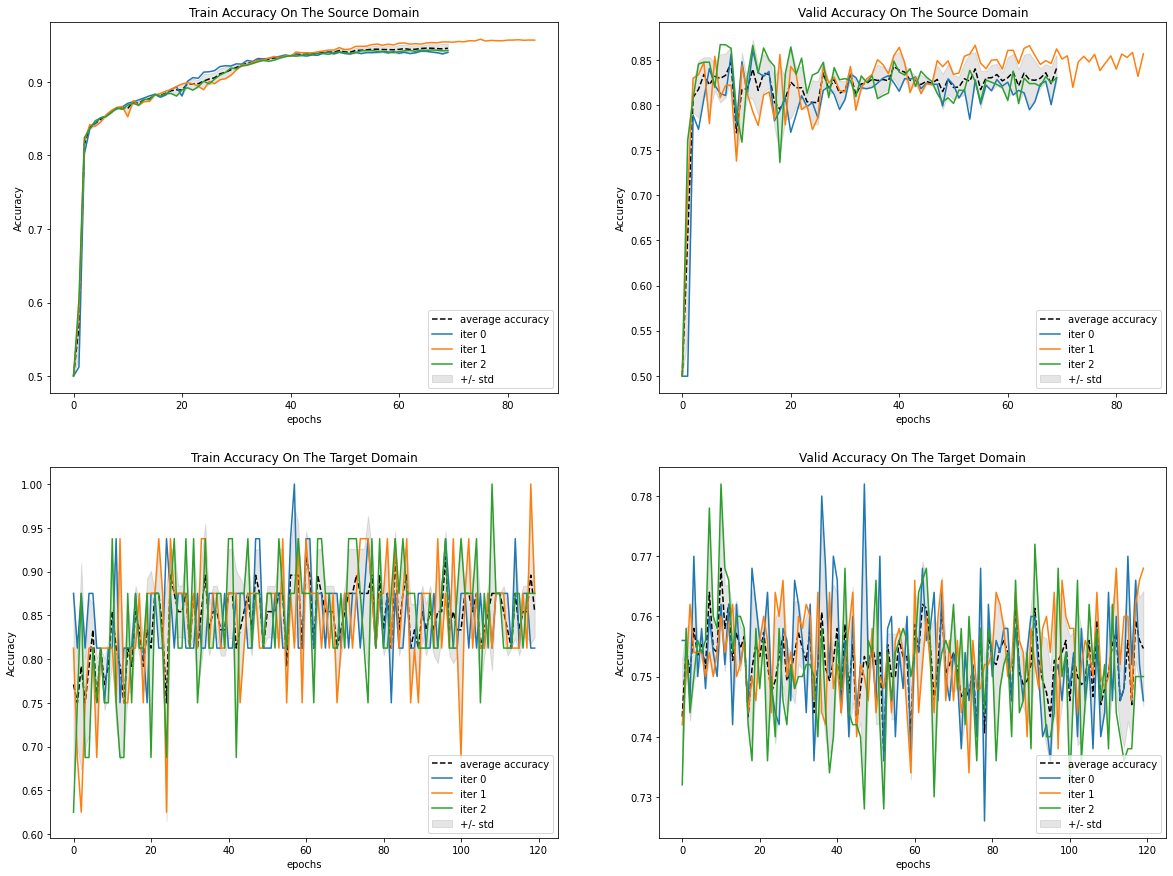

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 20

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 50 MIMIC samples

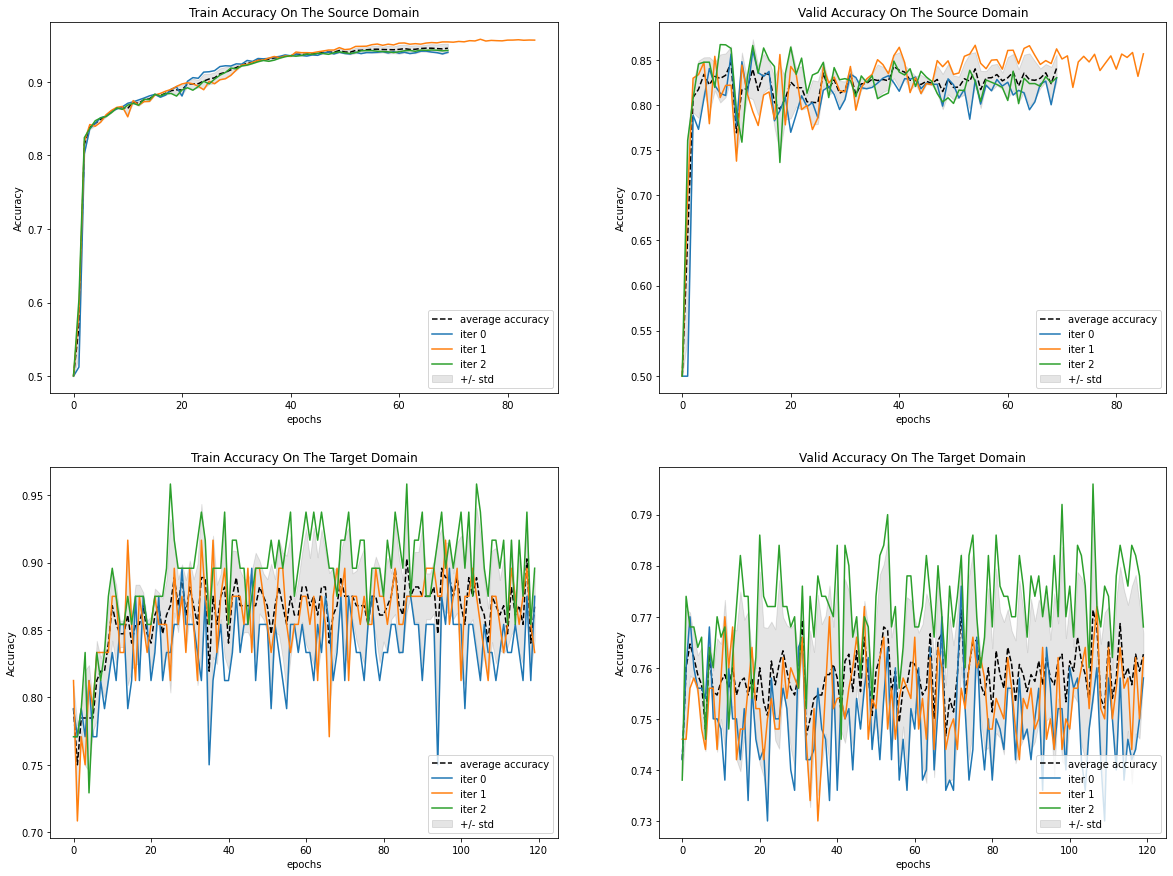

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 50

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 100 MIMIC samples

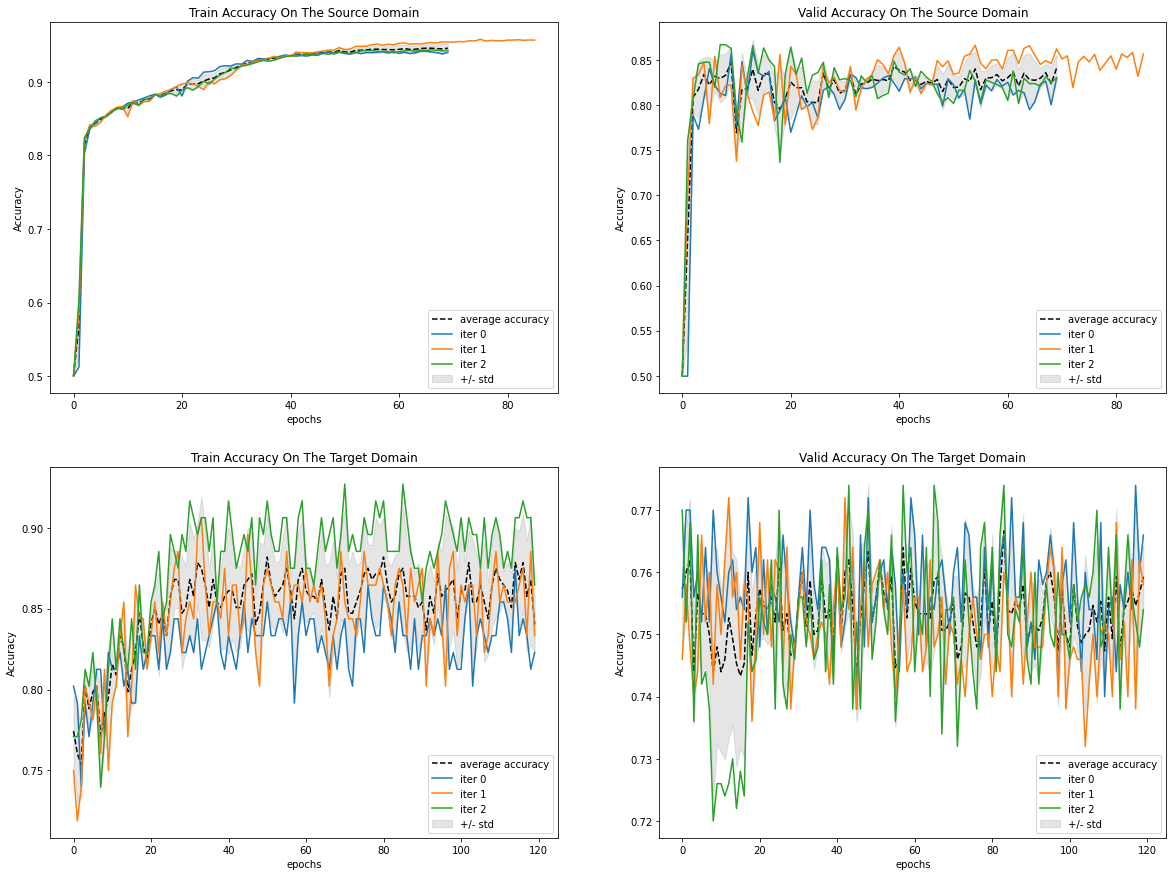

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 100

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 200 MIMIC samples

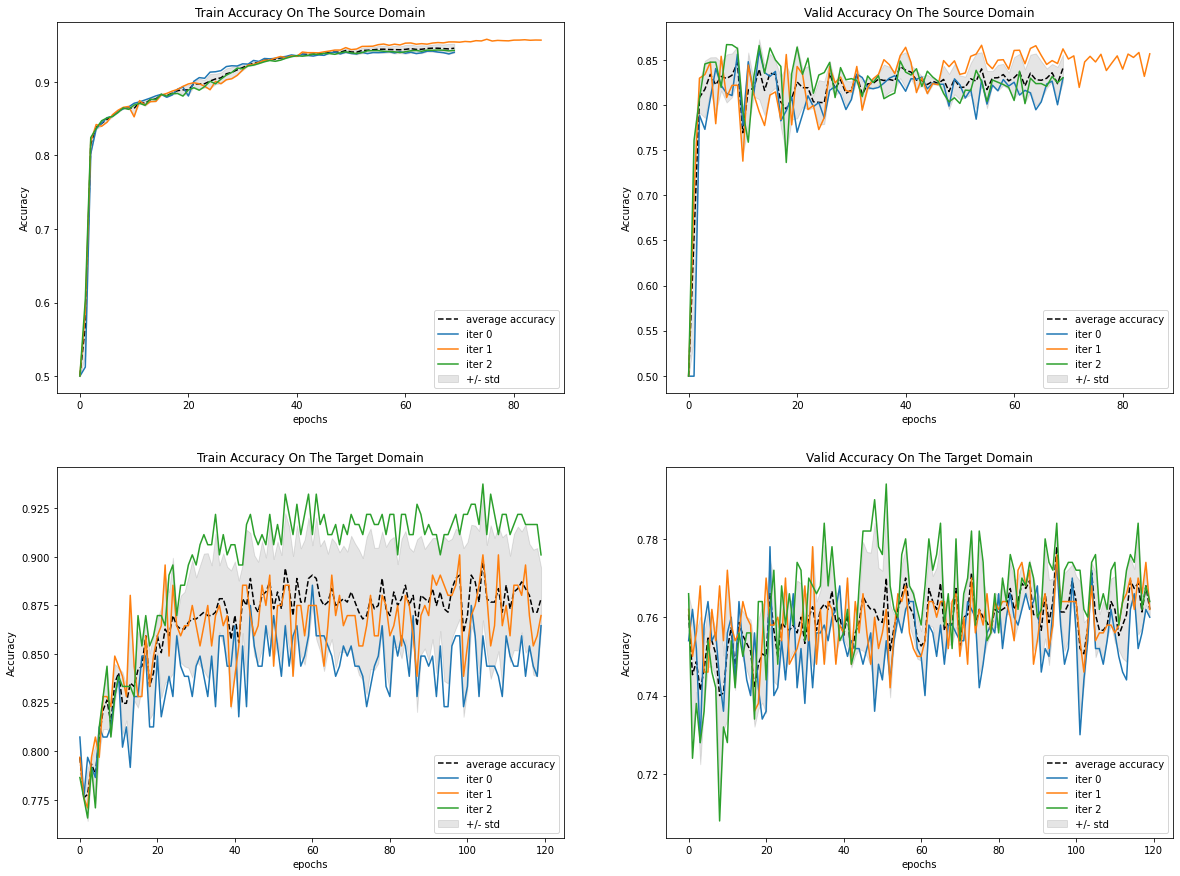

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 200

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 500 MIMIC samples

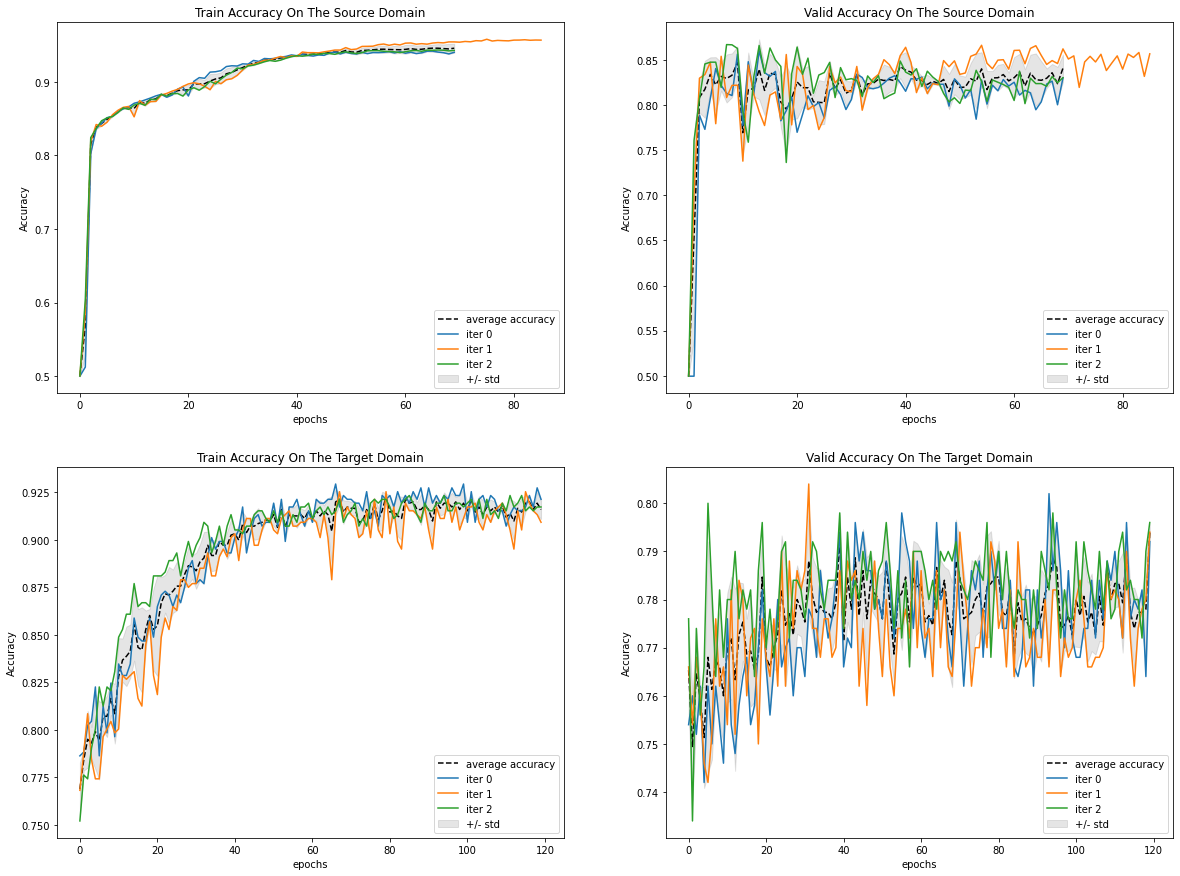

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 500

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 1000 MIMIC samples

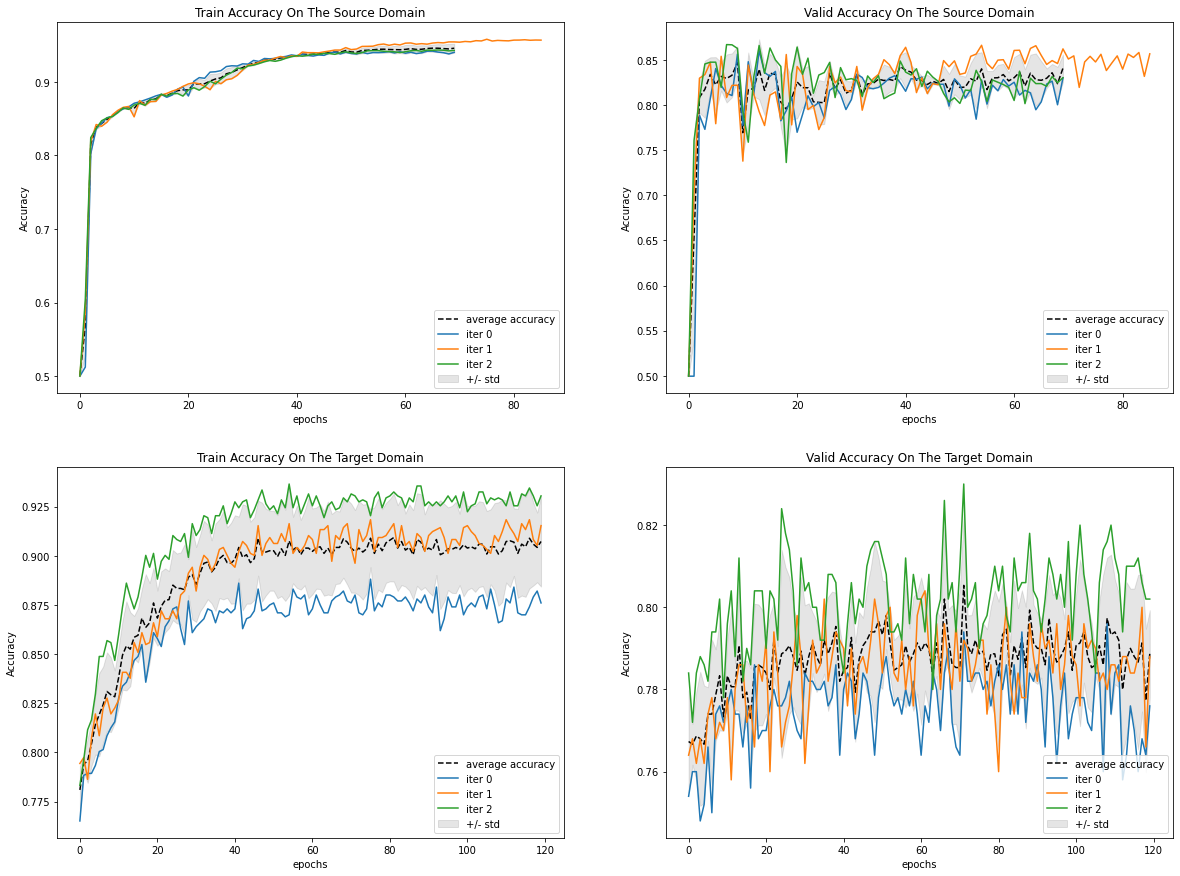

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 1000

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

# Summarize training metrics for trained models

In [26]:
target_meta = model_meta[model_meta['phase'] == 'target']

training_cols = ['final_train_loss', 'final_valid_loss', 'final_valid_acc', 'mimic_final_test_acc', 'chexpert_final_test_acc']

In [27]:
target_meta.groupby('n_target_samples').mean(numeric_only=True)[training_cols]

final_train_loss  final_valid_loss  final_valid_acc  \
n_target_samples                                                        
20                        0.572793          0.615233         0.754667   
50                        0.559105          0.615870         0.762667   
100                       0.575776          0.612973         0.759333   
200                       0.556585          0.610525         0.762000   
500                       0.539361          0.602106         0.794000   
1000                      0.546209          0.601482         0.788667   

                  mimic_final_test_acc  chexpert_final_test_acc  
n_target_samples                                                 
20                            0.764686                 0.815250  
50                            0.767193                 0.829125  
100                           0.774756                 0.831917  
200                           0.779560                 0.846500  
500                           0.793516                 0.849375  
1000                          0.799407                 0.844333